# Mass Flux Oscillation

 But why is a 92-minute oscillation in the cloud size distribution significant?

 I have examined many properties of the cloud field, and it appears that the total mass flux of the cloud field has a close relationship with the slope of the cloud size distribution. Here, I repeat the GP regression workflow for mass flux.

In [1]:
# Set up local project directory path
from pathlib import Path
from tqdm.notebook import trange, tqdm
import sys

project_src = Path('../src').resolve().as_posix()
sys.path.insert(0, project_src)

try:
    import lib.config

    from reg.samples import cloud_dz as sample
    from reg.distributions import kde as distribution
    from reg.slopes import piecewise_linear as slope
except Exception:
    raise Exception("Issue with dynamic import")

config = lib.config.read_config()
pwd = Path(config['pwd'])
case = Path(config['case'])
src = Path('../output')

In [2]:
# Import modules needed for the rest of the notebook
from IPython.display import Image 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import xarray as xr

import pyarrow.parquet as pq

# Pytorch + GP
import torch, gpytorch
from gpytorch.priors import NormalPrior, UniformPrior

import sklearn.preprocessing as skl_prep

In [3]:
plt.style.use('classic')
sns.set_palette('deep')
%matplotlib inline

 Of course, we will be using the old BOMEX dataset with a simple swamp ocean. For the sake of this notebook, I will simply calculate the total mass flux per minute. Since the vertical profile of mass flux remains consistent, calculating the mean yields the same result.

In [4]:
p = Path(f'{case}/../BOMEX_SWAMP/BOMEX_1536x512x128_25m_1s_ent_ocean_50m.nc')
df = xr.open_dataset(p)
df.MFTETCOR

<xarray.DataArray 'MFTETCOR' (time: 1440, z: 192)>
[276480 values with dtype=float32]
Coordinates:
  * z        (z) float32 12.5 37.5 62.5 87.5 ... 4712.5 4737.5 4762.5 4787.5
  * time     (time) float32 180.00035 180.00104 ... 180.99895 180.99965
Attributes:
    long_name:  Tetrahedral Core Vertical Mass Flux
    units:      kg/m2/s

In [5]:
y = np.array(np.sum(df.MFTETCOR.T, axis=0)[720:])
x = np.arange(len(y))

x_tr = torch.tensor(x, dtype=torch.double)
y_tr = torch.tensor(y, dtype=torch.double)

 The following plot shows the timeseries of total mass flux. Again, it looks very noisy with a very little evidence of oscillation behaviour. The workflow remains exactly the same as the cloud size distribution.

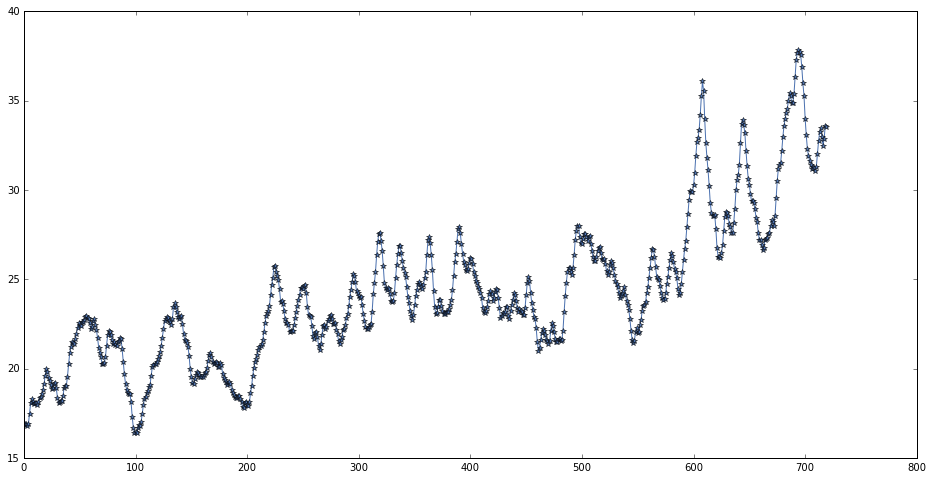

In [6]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
ax.plot(x_tr, y_tr, '*-')

In [7]:
class SmoothGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SmoothGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [8]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-4)
)
model = SmoothGPModel(x_tr, y_tr, likelihood)

# Initialize kernels
model.cov_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(50.)
)

model.cov_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(50.),
    period_length = torch.tensor(90.),
)

model.double()

SmoothGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (cov_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 100
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

In [10]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 2.160912862708812
mean_module.constant                       	 6.007464677445435
cov_module.kernels.0.raw_outputscale       	 4.058635452956267
cov_module.kernels.0.base_kernel.raw_lengthscale 	 43.99468756207563
cov_module.kernels.1.raw_outputscale       	 4.159495723852845
cov_module.kernels.1.base_kernel.raw_lengthscale 	 42.32445177338377
cov_module.kernels.1.base_kernel.raw_period_length 	 92.58386354329757


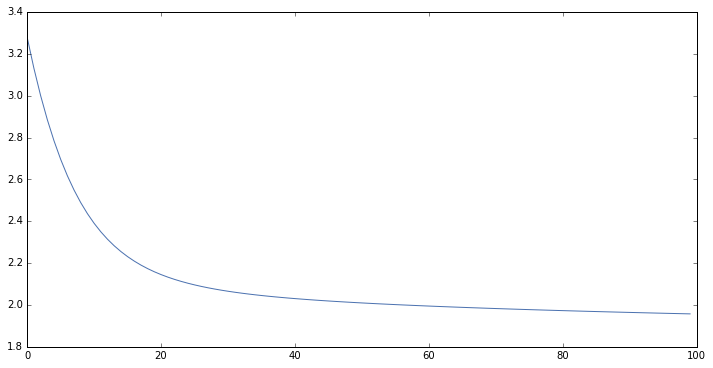

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

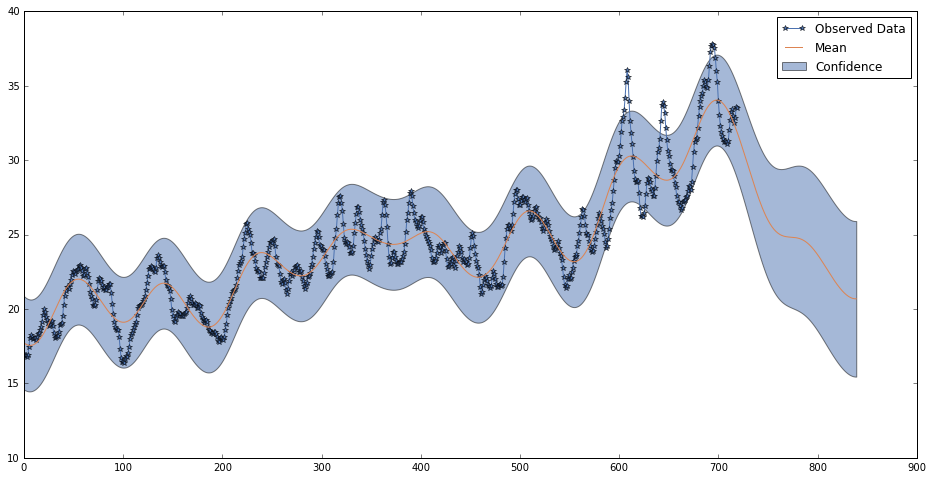

In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

offset = 120

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad():
    x_test = torch.arange(len(x_tr)+120, dtype=torch.double)
    observed = likelihood(model(x_test))

with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    lower, upper = observed.confidence_region()
    
    ax.plot(x_tr.numpy(), y_tr.numpy(), '*-')
    ax.plot(x_test.numpy(), observed.mean.numpy())
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

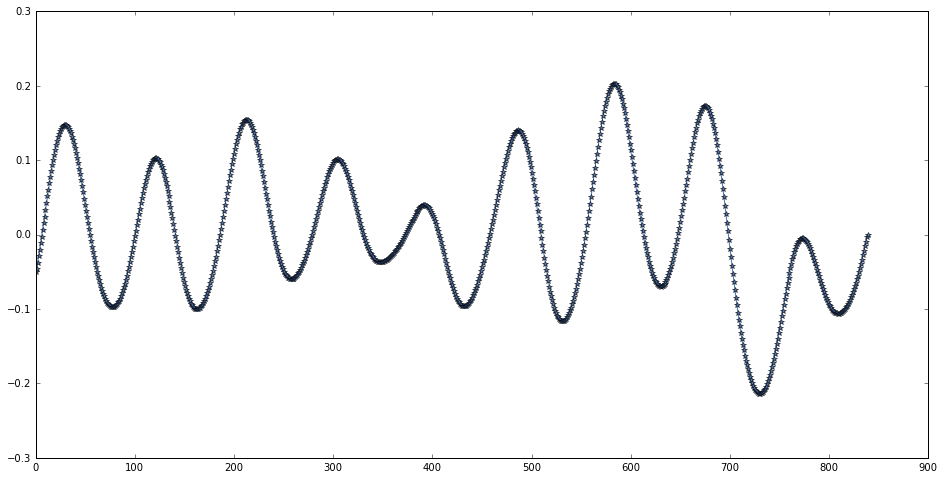

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(x_test.numpy(), np.gradient(observed.mean.numpy()), '*-')

x_orig = x_tr.clone().detach()
y_orig = y_tr.clone().detach()

y_tr = torch.tensor(np.gradient(observed.mean)[:-offset], dtype=torch.double)
x_tr = torch.tensor(np.arange(len(y_tr)), dtype=torch.double)

In [14]:
class PeriodicGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(PeriodicGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ZeroMean()
        
        self.cov_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel()
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [15]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-4)
)
model = PeriodicGPModel(x_tr, y_tr, likelihood)

hyper_params = {
    'cov_module.base_kernel.lengthscale': torch.tensor(30.),
    'cov_module.base_kernel.period_length': torch.tensor(90.),
}
model.initialize(**hyper_params)

model.cov_module.base_kernel.register_prior(
    "lengthscale_prior", 
    UniformPrior(1, 100), 
    "lengthscale"
)
model.cov_module.base_kernel.register_prior(
    "period_length_prior", 
    UniformPrior(30, 120), 
    "period_length"
)

model.double()

PeriodicGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (cov_module): ScaleKernel(
    (base_kernel): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
      (lengthscale_prior): UniformPrior(low: 1.0, high: 100.0)
      (period_length_prior): UniformPrior(low: 30.0, high: 120.0)
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [16]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:48} \t {param.item()}")
    
print(f"\n {model.cov_module.base_kernel}")

likelihood.noise_covar.raw_noise                 	 0.0
cov_module.raw_outputscale                       	 0.0
cov_module.base_kernel.raw_lengthscale           	 30.0
cov_module.base_kernel.raw_period_length         	 90.0

 PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
  (lengthscale_prior): UniformPrior(low: 1.0, high: 100.0)
  (period_length_prior): UniformPrior(low: 30.0, high: 120.0)
)


 And I wish I had access to CUDA cores.

In [17]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-2)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 1000
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    period = model.cov_module.base_kernel.raw_period_length.item()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f} Period: {period:.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

In [18]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 -6.676200405348277
cov_module.raw_outputscale                 	 -2.34970181686131
cov_module.base_kernel.raw_lengthscale     	 25.88269560016841
cov_module.base_kernel.raw_period_length   	 91.94341986845758


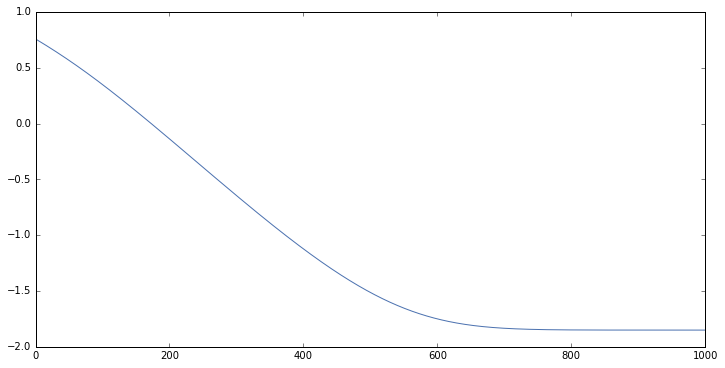

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [20]:
print(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): PeriodicGPModel(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ZeroMean()
    (cov_module): ScaleKernel(
      (base_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
        (lengthscale_prior): UniformPrior(low: 1.0, high: 100.0)
        (period_length_prior): UniformPrior(low: 30.0, high: 120.0)
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)


In [21]:
model.eval()
likelihood.eval()

with torch.no_grad():
    x_test = torch.arange(len(x_tr)+360, dtype=torch.double)
    observed = likelihood(model(x_test))

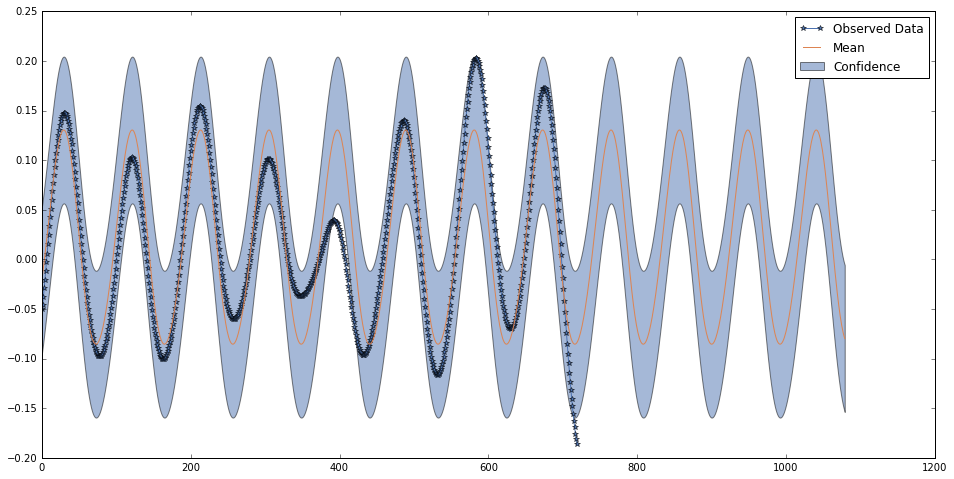

In [22]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    lower, upper = observed.confidence_region()
    
    ax.plot(x_tr.numpy(), y_tr.numpy(), '*-')
    ax.plot(x_test.numpy(), observed.mean.numpy())
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

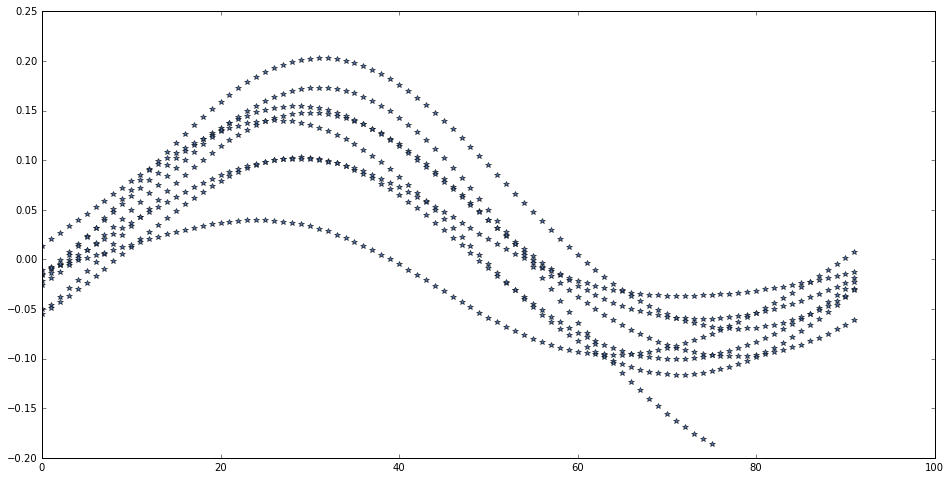

In [23]:
# Redefine training domain
x_tr_rep = np.mod(x_tr, 92)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (16, 8))
ax.plot(x_tr_rep, y_tr, '*')

 At this point it is a little disturbing. Total mass flux across the cloud field is a *better* indicator of oscillatory growth of cloud field! All I had to do was to add everything up and make a timeseries out of it. 
 
 Still, it is nice that we have confirmed this is the case. We did come to this conclusion backwards, but the main point is that the transition between the two phases of cloud growth can be directly related to a quantifiable meaure.

 It is, then, not surprising to see that the slope of the cloud size distribution and total mass flux are closely related. What is surprising, and perhaps more important, is that it is also very closely related to cloud cover. That is, total cloud cover over a domain also oscillates with total mass flux and the cloud size distribution. I won't repeat the GP regression for cloud cover, because it will be exactly same as this one.

 Given the result, one cloud look at the cloud cover over time and infer the strength of mass flux (and naturally, entrainment) over the cloud field. Also, we can perform a GP regression in 2-dimensional (height, time) space using the vertial mass flux (or entrainment) profile. Because both mass flux entrainment appear to oscillate with a 92-minute period while maintaining the general shape of the vertical profile, it means that the uncertainty involved in calculating the mean vertical mass flux and entrainment profiles will be a lot smaller once we account for the the oscillation.

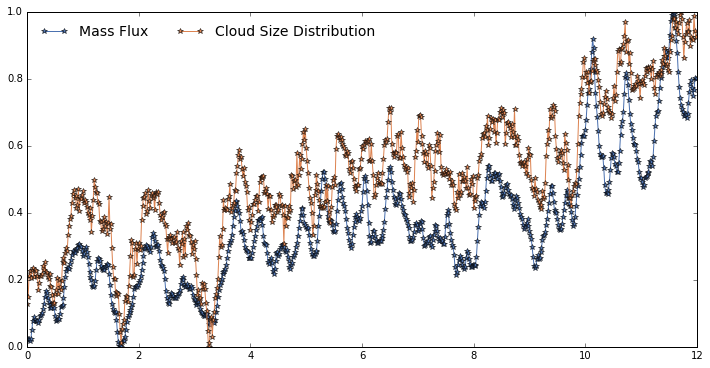

In [25]:
p = Path(f'{case}/../BOMEX_SWAMP/BOMEX_1536x512x128_25m_1s_ent_ocean_50m.nc')
df = xr.open_dataset(p)

y_mf = np.array(np.nanmean(df.MFTETCOR.T, axis=0)[720:])

p = Path('../output/slope_BOMEX_SWAMP_COR_KDE_PIECEWISE.pq')
ds = pq.read_pandas(p).to_pandas()

y_sl = ds.slope.to_numpy()

x_c = np.arange(len(y_sl)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(x_c, skl_prep.minmax_scale(y_mf[:720, None], axis=0), '*-', label='Mass Flux')
ax.plot(x_c, skl_prep.minmax_scale(-y_sl[:720, None], axis=0), '*-', label='Cloud Size Distribution')

ax.legend(loc=0, ncol=2, frameon=False, fontsize=14)

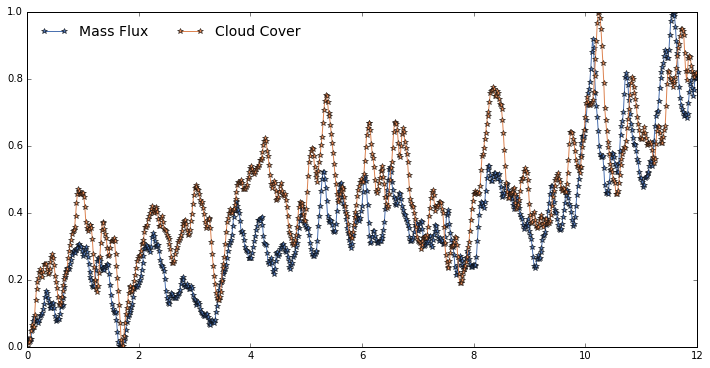

In [26]:
p = Path(f'{case}/../BOMEX_SWAMP/BOMEX_1536x512x128_25m_1s_ent_ocean_50m.nc')
df = xr.open_dataset(p)

y_mf = np.array(np.nanmean(df.MFTETCOR.T, axis=0)[720:])

y_cld = np.array(df.CLDSHD[720:])

x_c = np.arange(len(y_cld)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.plot(x_c, skl_prep.minmax_scale(y_mf[:720, None], axis=0), '*-', label='Mass Flux')
ax.plot(x_c, skl_prep.minmax_scale(y_cld[:720, None], axis=0), '*-', label='Cloud Cover')

ax.legend(loc=0, ncol=2, frameon=False, fontsize=14)